    Jupyter notebook for practicing with graph data science.

    Much of the code here is patterned after chapter 2 in
        Graph Data Science with Neo4j
        Estelle Scifo, Packt Publishing Ltd, 2023

    Michael A. Goodrich
    Brigham Young University

    March 2023

---


Requires
* os
* matplotlib
* pandas

---

We'll begin by reading in a data set from a csv file into a pandas dataframe. We'll then inspect the first few rows of the dataframe to get a feel for the data.

In [2]:
""" Get data example from Kaggle 

    https://www.kaggle.com/datasets/rajugc/imdb-top-250-movies-dataset

    Copy code from the following to read in data:

    https://www.kaggle.com/code/rajugc/imdb-top-250-movies-eda

    The code is released under the Apache 2.0 open source license.
"""

import pandas as pd

df = pd.read_csv('databases/IMDB Top 250 Movies.csv') # prefix this file name with the directory in which you stored it
df.head()   # This function returns the first n rows for the object based on position. 
            # It is useful for quickly testing if your object has the right type of data in it.
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


_Show the information about what is contained in each column_

In [3]:
df.info()
# This method prints information about a DataFrame including the index dtype and 
# columns, non-null values and memory usage.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


_Gather some summary information about which genres are present in the data_

In [4]:
df.value_counts('genre')

genre
Drama                         19
Crime,Drama                   14
Animation,Adventure,Comedy    10
Biography,Drama,History        9
Crime,Drama,Mystery            9
                              ..
Crime,Mystery,Thriller         1
Crime,Sci-Fi                   1
Adventure,Comedy,Sci-Fi        1
Adventure,Comedy,Fantasy       1
Adventure,Comedy,Drama         1
Length: 104, dtype: int64

In [5]:
print(set(df.columns))

{'certificate', 'box_office', 'directors', 'writers', 'budget', 'casts', 'rating', 'rank', 'tagline', 'run_time', 'name', 'year', 'genre'}


*** 
The tutorials that I've been reading about suggest a linear process for constructing and querying a graph database.
The first step is to extract data from whatever source you have into usable form. This could require desiging a webcrawler to scrape Netflix recommendations, interfacing through an API to obtain Twitter interaction networks, writing a parser to turn a set of Google scholar pages into csv file, or querying an existing cloud database to find how topics on Wikipedia are related.  This can be labor-intensive and can require a high level of skill. Since this class is focused on network analysis, we'll start with data that someone else extracted. The example above is from kaggle.

The next steps are

 - Read the csv file into a pandas dataframe (DatabaseManager.py)
 - Turn rows and columns in the dataframe into a labeled graph (GraphDatabaseManager.py)
 - Use graph projections to infer new relationships from the labeled graph
 - Use network analysis tools to extract patterns and useful information from the graph projections
 - Turn the graph projections into a useful network embedding
 - Use ML and statistical techniques to generate predictions from the network embedding

***

A _graph database_ is just a graph model of the database. The naive way to construct the graph database is to create a node for each row and column entry, and then add edges between nodes on the same row. In practice, this is not effective because only some of the relationships between the data in the columns is of interest. 

We approach this by creating a schema that describes the relationships that we care about. The schema should be set up in a way that allows us to answer questions that we might ask. For the movie database, I'll use the following schema.

![Graph schema](GraphSchema.drawio.svg)

See Neo4j book, page 31

This schema emphasizes movies, genres, and ratings. (I actually haven't played with ratings yet.)

***




We now need to go through the database and create a node for each movie, genre, movie certificate, and person. There are graph database query tools for doing this (e.g., Cypher in Neo4j), but I'm trying to teach this without requiring you to learn a lot of new tools, so I wrote code that extracts movie information into _nodes_. Each node will have metadata, describing some of the infromation for what the node represents. 

We'll then create _edges_ using the "resource description framework" (RDF), which represents relationships between nodes using a _subject predicate object_ relationship template. Don't worry too much about what this means because I haven't implemented edge labeling in my code. I just wanted you to see the reference.
***

Let's begin by looking at the entire graph. It's big so rendering it is slow.


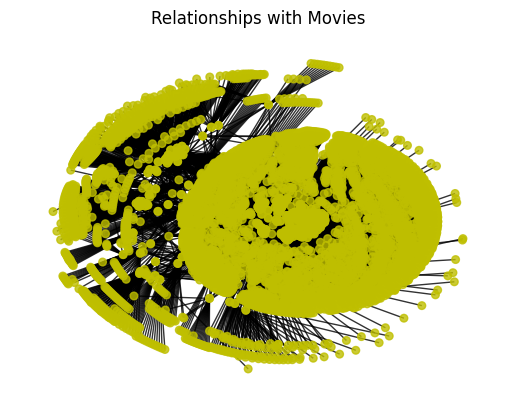

In [6]:
from DataScienceManager import DataScienceManager
from NetworkUtilities import networkHandler

manager = DataScienceManager('databases/IMDB Top 250 Movies.csv')
manager.ShowUnifiedGraph(pause=False)


There is obviously a structure in this graph, but the structure isn't surprising since it's based on who is in what movie. We'll explore structures that emerge when we query the graph. What makes graph databases interesting is that we can use use graph operations to extract relationships between entitites from things like path connections.

Let's begin by understanding the pairwise relationship between directors and movies.

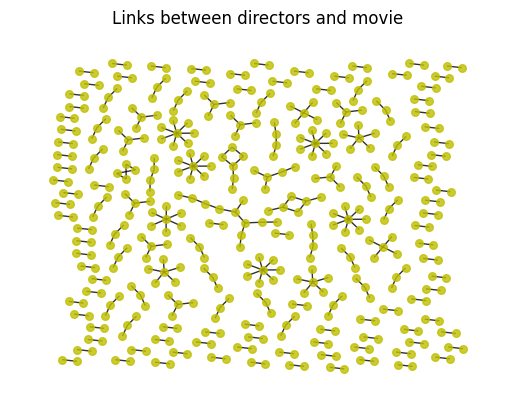

In [7]:

manager.ShowBipartiteSubgraph('directors',pause=False)


Observe that each node has at least one neighbor. In fact, most of the nodes have only one neighbor. These two-node subgraphs tell us that a lot of directors have only directed one movie that made it into the database.

The hub-and-spoke subgraphs are also interesting. They indicate either a director who has directed multiple movies or multiple directors who shared credit for a single movie. I don't know which is more probable without looking more carefully at the data.

The other subgraphs of interest look like line graphs with some spurs. Those are sequences of movie --> directed by X <-- who also directed move Y.

***

The most important structural property of the graph is that it is bipartite. One partition is directors, and the other partition is movies. Because the graph schema only has edges between movies and directors, there aren't (a) edges between two different movies or (b) edges between two different directors. 

We'll exploit the bipartite structure in a moment. But first, it's useful to look at all the bipartite graphs that we constructed using the graph schema. 

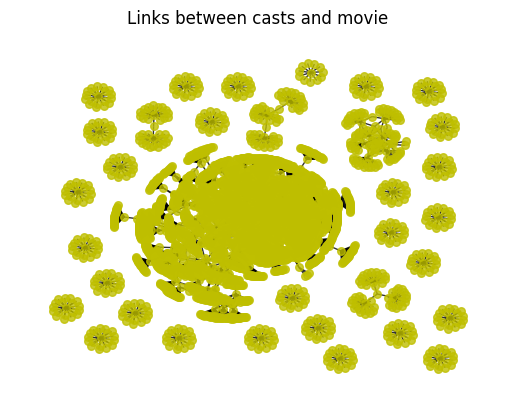

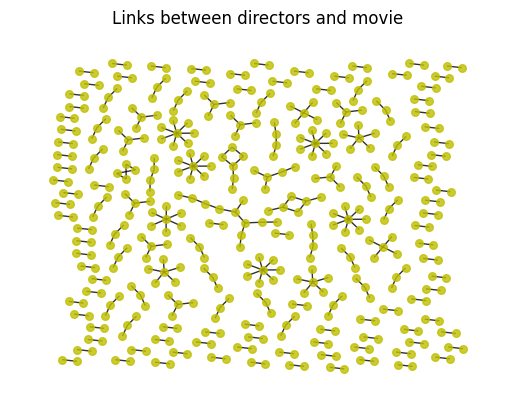

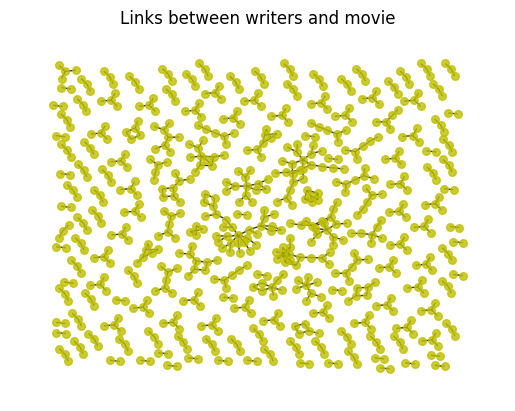

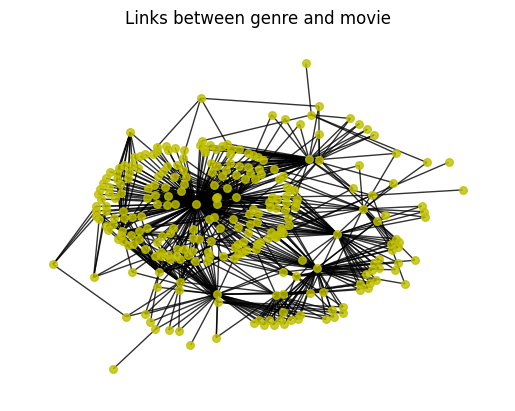

In [8]:
manager.ShowAllBipartiteGraphs(pause=False)


The most interesting graph is the relationship be movies and casts. It reminds me of cauliflower. The diconnected components are movies whose casts did not act in any of the other movies in the database. There is a large component in the graph which shows that some actors have been in a lot of movies from the database.
*** 



Try to recall when we talked about bipartite graphs near the start of the semester. We were able to come up with a special type of matrix representation. The rows represented vertices in the first partition and the columns represented vertices in the second partition. 



![Special form of the incidence matrix for a bipartite graph](BipartiteGraph_IncidenceMatrix.png)

(Special form of the incidence matrix for a bipartite graph)

When a graph is bipartite and when we represent the graph using the special form of the incidence matrix, we can "project out" one of the sets of nodes.

![Projecting out one of the partitions](BipartiteGraphProjectionOperator.png)

__Projection is an important operations for graph databases.__ Since I'm not using an existing graph database, I wrote my own projection operator. Rather than extract the special form of the incidence matrix, I implemented the projection by finding two step paths between nodes. It's useful to see the graph that is produced beginning with the bipartite graph of writers/directors and movies and then projecting out movies.



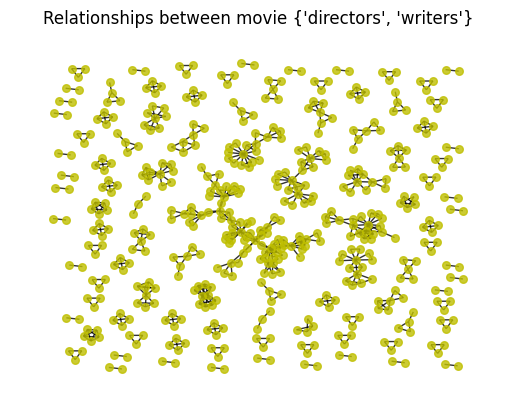

In [2]:
from DataScienceManager import DataScienceManager
from NetworkUtilities import networkHandler
manager = DataScienceManager('databases/IMDB Top 250 Movies.csv')
writer_director_projection, writer_director_title = manager.GetProjection({'writers','directors'},biggest_component=False)
wd_network_handler = networkHandler(writer_director_projection)
wd_network_handler.ShowNetwork(writer_director_projection, title=writer_director_title, pause=False)


The projection operator is a form of inference in the graph database. It takes the graph schema and infers new information. In the case of the graph above, the new information is "which writers and directors know each other".

It's informative to look at just the largest component, because doing so identifies a fundamental structure that doesn't feel like it's perculiar to just a small subset of the network. There are actually a couple of interesting compoments, but I'd argue that the largest component captures the sturctures implicit in the other large-ish components.

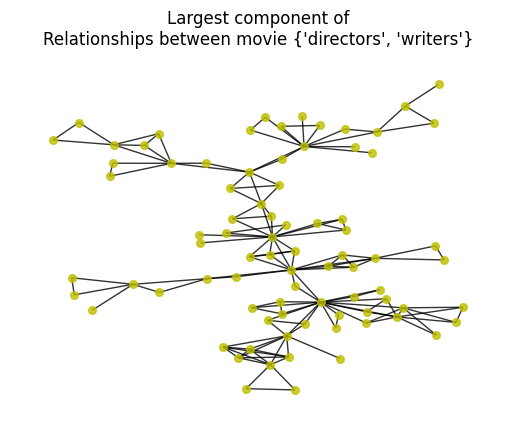

In [3]:
writer_director_projection, writer_director_title = manager.GetProjection({'writers','directors'},biggest_component=True)
manager.ShowProjection(writer_director_projection, title=writer_director_title, pause=False)


Once we have the network, we can start to apply the network analysis tools that we've developed. Note that I've only implemented a portion of the network statistics and that you should add your own.

In [4]:
wd_network_handler = networkHandler(writer_director_projection)
wd_network_handler.getNetworkStatistics()


Degree assortativity is  -0.24762190751109123
	A positive sign means the network is assortative,
	and a negative sign means the network is disassortative


The dendrogram is really slow because it uses the Newman Girvan betweenness algorithm. The code is also ad hoc because I have a magic number for the figure number.

/Users/mike/Dropbox/Mac/Documents/Classes/CS 575/Winter 2023/Code/GraphDataScience_withSNAP/NetworkUtilities.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  else: plt.waitforbuttonpress(0.001)


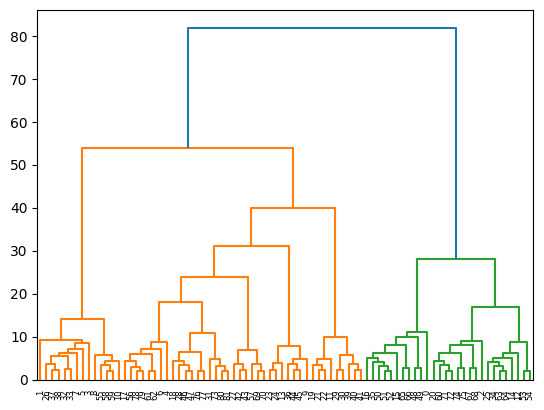

In [5]:
wd_network_handler.showDendrogram(figureNumber = 10, wait_for_button = False)


We can find communities and replot the graph to understand more about the structure.

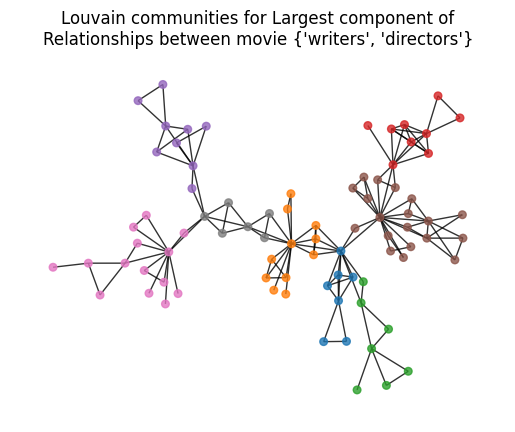

In [19]:
wd_colormap = wd_network_handler.getAgentColors_from_LouvainCommunities()
writer_director_title = "Louvain communities for " + writer_director_title
manager.ShowProjection(writer_director_projection, colormap = wd_colormap, title=writer_director_title, pause=False)


Who knows whom graph for all writers, directors, cast members.

Degree assortativity is  0.01363054119758411
	A positive sign means the network is assortative,
	and a negative sign means the network is disassortative


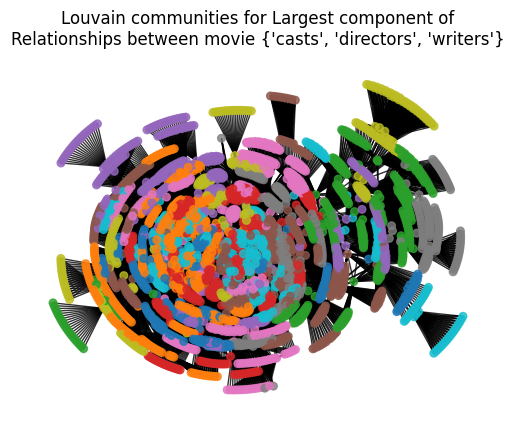

In [7]:
writer_director_cast_projection, writer_director_cast_title = manager.GetProjection({'casts','directors','writers'},biggest_component=True)
wdc_network_handler = networkHandler(writer_director_cast_projection)
wdc_network_handler.getNetworkStatistics()
wdc_colormap = wdc_network_handler.getAgentColors_from_LouvainCommunities()
writer_director_cast_title = "Louvain communities for " + writer_director_cast_title
manager.ShowProjection(writer_director_cast_projection, colormap = wdc_colormap, title=writer_director_cast_title, pause=False)
   

When you look at the graph above, you probably see structure. The graph exhibits what is sometimes called an _onion_ structure since there appear to be layers around a central core. We can formalize what it means for a graph to have an onion structure, but doing so requires us to understand what a _k-core_ is.

Quoting from section 7.2.2 _Networks_, 2nd edition, by Mark Newman 

"By contrast with a __clique__, where each node is joined to all others, a __k-core__ is a connected set of nodes where each is joined to at least k others" [emphasis added].

There is a simple algorithm for finding the k-core. The algorithm repeats the following until no more nodes can be removed:

 - remove all nodes that have degree less than k
 - remove their incident edges

To do
 - Core and satellites structure
 - K cores and communities with application to contagion
 - Graph embedding: PCA, fiedler vectors, node2vec